In [19]:
import pandas as pd
import os
import evaluate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tqdm

In [2]:
BASEPATH = "/mnt/sohn2022/Adrian/llm-revise-indication-notes/inference/results/llm_balanced_test_dataset"

In [4]:
!ls /mnt/sohn2022/Adrian/llm-revise-indication-notes/inference/results/llm_balanced_test_dataset

BioMistral_BioMistral-7B_0_10000.csv
BioMistral_BioMistral-7B_0_100.csv
google_gemma-2-9b-it_0_10000.csv
gpt4o_0_1000.csv
gpt4o_1000_2000.csv
gpt4o_2000_3000.csv
gpt4o_3000_4000.csv
gpt4o_4000_5000.csv
gpt4o_5000_6000.csv
gpt4o_6000_7000.csv
gpt4o_7000_8000.csv
gpt4o_8000_9000.csv
gpt4o_9000_10000.csv
meta-llama_Meta-Llama-3.1-8B-Instruct_0_10000.csv
meta-llama_Meta-Llama-3.1-8B-Instruct_10k.csv
mistralai_Mistral-7B-Instruct-v0.3_0_10000.csv
mistralai_Mistral-7B-Instruct-v0.3_10k.csv
OpenMeditron_Meditron3-8B_0_10000.csv
OpenMeditron_Meditron3-8B_0_100.csv
Qwen_Qwen2.5-7B-Instruct_0_10000.csv
StanfordAIMI_RadLLaMA-7b_0_100.csv


In [5]:
csv_files = os.listdir(f"{BASEPATH}")
gpt4o = []
for csv_file in csv_files:
    if "gpt4o" in csv_file:
        gpt4o.append(pd.read_csv(os.path.join(BASEPATH, csv_file)))
gpt4o = pd.concat(gpt4o)

In [37]:
mistral = pd.read_csv(f"{BASEPATH}/mistralai_Mistral-7B-Instruct-v0.3_0_10000.csv").fillna("")
llama = pd.read_csv(f"{BASEPATH}/meta-llama_Meta-Llama-3.1-8B-Instruct_0_10000.csv").fillna("")
qwen = pd.read_csv(f"{BASEPATH}/Qwen_Qwen2.5-7B-Instruct_0_10000.csv").fillna("")
gemma = pd.read_csv(f"{BASEPATH}/google_gemma-2-9b-it_0_10000.csv").fillna("")

biomistral =  pd.read_csv(f"{BASEPATH}/BioMistral_BioMistral-7B_0_10000.csv").fillna("")
meditron = pd.read_csv(f"{BASEPATH}/OpenMeditron_Meditron3-8B_0_10000.csv").fillna("")

In [7]:
rouge = evaluate.load('rouge')
def compute_rougeL(data, gt_col="radiologist_indication", pred_col="llm_indication"):
    predictions = data[pred_col].tolist()
    references = data[gt_col].tolist()
    # Compute ROUGE-L score
    rouge_scores = rouge.compute(predictions=predictions, references=references)
    return rouge_scores['rougeL']

In [24]:
rouge.compute(predictions=["hello"], references=["hellow rodl"])

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}

In [27]:
def compute_rougeL_bootstrap_individual_scores(data, gt_col="radiologist_indication", pred_col="llm_indication", n_bootstrap=10000):
    predictions = data[pred_col].tolist()
    references = data[gt_col].tolist()
    n_samples = len(predictions)
    
    # Compute individual ROUGE-L scores
    individual_scores = []
    for i in tqdm.tqdm(range(len(predictions)), position=0, leave=True):
        rouge_score = rouge.compute(predictions=[predictions[i]], references=[references[i]])
        individual_scores.append(rouge_score['rougeL'] * 100)  # Convert to percentage
    
    individual_scores = np.array(individual_scores)
    
    # Bootstrapping
    bootstrap_means = []
    for _ in range(n_bootstrap):
        # Resample scores with replacement
        resampled_scores = np.random.choice(individual_scores, size=n_samples, replace=True)
        # Compute the mean of resampled scores
        bootstrap_means.append(np.mean(resampled_scores))
    
    bootstrap_means = np.array(bootstrap_means)
    
    # Compute statistics
    mean_score = np.mean(bootstrap_means)
    std_score = np.std(bootstrap_means)
    ci_lower = np.percentile(bootstrap_means, 2.5)
    ci_upper = np.percentile(bootstrap_means, 97.5)
    
    return mean_score, std_score, ci_lower, ci_upper

In [38]:
model_dfs = [mistral, llama, gemma, qwen, biomistral, meditron, gpt4o]
model_names = [
    'Mistral-7B-Instruct-v0.3', 
    'Llama-3.1-8B-Instruct', 
    'Gemma-2-9B-it',
    'Qwen-2.5-7B-Instruct',
    'BioMistral-7B', 
    'Meditron3-8B', 
    'GPT-4o'
]

results = []

for i in tqdm.tqdm(range(len(model_names))):
    df, name = model_dfs[i], model_names[i]
    print(name)
    print("="*20)
    mean_score, std_score, ci_lower, ci_upper = compute_rougeL_bootstrap_individual_scores(df, n_bootstrap=10000)
    results.append({
        'model': name,
        'mean_score': mean_score,
        'std_score': std_score,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

# For the Referring Physician
mean_score, std_score, ci_lower, ci_upper = compute_rougeL_bootstrap(
    gpt4o, pred_col="original_indication", n_bootstrap=10000)
results.append({
    'model': 'Referring Physician',
    'mean_score': mean_score,
    'std_score': std_score,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

# Create a DataFrame from results
results_df = pd.DataFrame(results)

  0%|                                                                                                 | 0/7 [00:00<?, ?it/s]

Mistral-7B-Instruct-v0.3


 14%|████████████▎                                                                         | 1/7 [15:54<1:35:27, 954.50s/it]

Llama-3.1-8B-Instruct


 14%|████████████▎                                                                         | 1/7 [16:09<1:36:56, 969.34s/it]


KeyboardInterrupt: 

In [40]:
results

[{'model': 'Mistral-7B-Instruct-v0.3',
  'mean_score': 17.8298345485882,
  'std_score': 0.12558570678132192,
  'ci_lower': 17.58496365233675,
  'ci_upper': 18.08038885761315}]

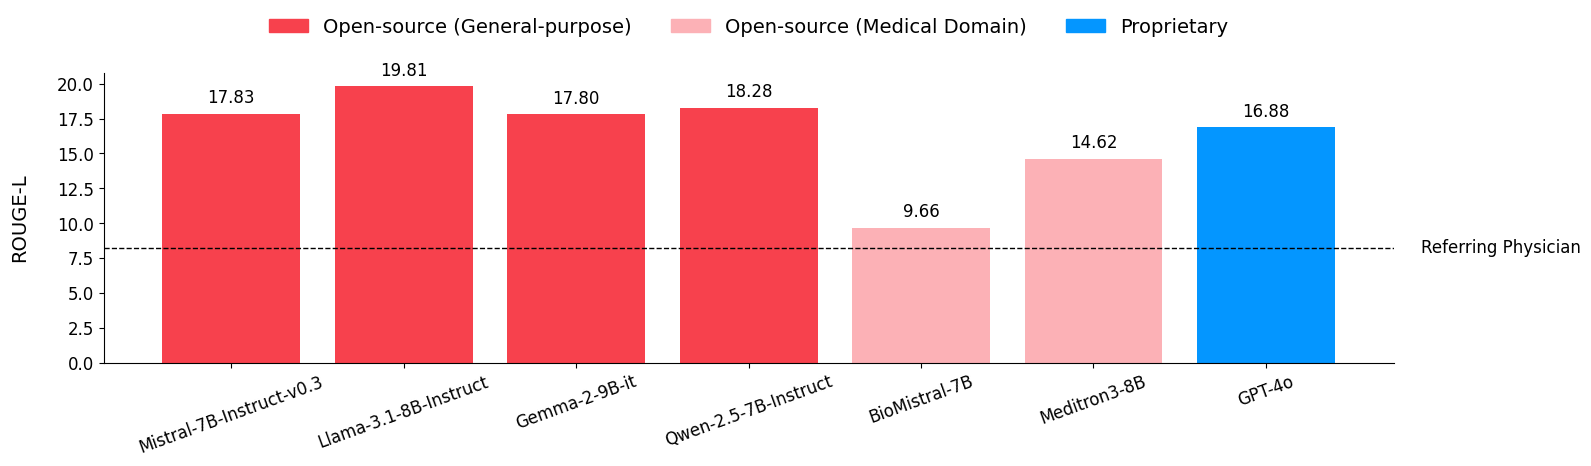

In [61]:
# Compute ROUGE-L scores for each model
# mistral_rougeL = compute_rougeL(mistral)
# llama_rougeL = compute_rougeL(llama)
# gemma_rougeL = compute_rougeL(gemma)
# qwen_rougeL = compute_rougeL(qwen)
# biomistral_rougeL = compute_rougeL(biomistral)
# meditron_rougeL = compute_rougeL(meditron)
# gpt4o_rougeL = compute_rougeL(gpt4o)
# referring_physician_rougeL = compute_rougeL(gpt4o, pred_col="original_indication")

# Prepare data for plotting
model_names = [
    'Mistral-7B-Instruct-v0.3', 
    'Llama-3.1-8B-Instruct', 
    'Gemma-2-9B-it',
    'Qwen-2.5-7B-Instruct',
    'BioMistral-7B', 
    'Meditron3-8B', 
    'GPT-4o', 
    'Referring Physician'
]
rougeL_scores = [mistral_rougeL, llama_rougeL, gemma_rougeL, qwen_rougeL, biomistral_rougeL, meditron_rougeL, gpt4o_rougeL, referring_physician_rougeL]
rougeL_scores_100 = [s * 100 for s in rougeL_scores]

referring_physician_rougeL_100 = referring_physician_rougeL * 100

# Plot the bar chart
fig, ax = plt.subplots(figsize=(16, 5))
bars = ax.bar(model_names[:-1], rougeL_scores_100[:-1], color=[
    '#F7414D', 
    '#F7414D', 
    '#F7414D', 
    '#F7414D', 
    '#FCB1B6', 
    '#FCB1B6', 
    '#0496FF'
])

ax.set_ylabel('ROUGE-L', labelpad=20, fontsize=14)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add the dotted black line for the Referring Physician
ax.axhline(y=referring_physician_rougeL_100, color='black', linestyle='--', linewidth=1, label='Referring Physician')
ax.text(len(model_names) - 1 - 0.1, referring_physician_rougeL_100, 'Referring Physician', 
        color='black', va='center', ha='left', fontsize=12)

# Add text labels on top of each bar
for bar, score in zip(bars, rougeL_scores_100[:-1]):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.5, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

for label in ax.get_xticklabels():
    label.set_fontsize(12) 
    label.set_rotation(20)

for label in ax.get_yticklabels():
    label.set_fontsize(12) 
    
general_legend = mpatches.Patch(color='#F7414D', label='Open-source (General-purpose)')
medical_legend = mpatches.Patch(color='#FCB1B6', label='Open-source (Medical Domain)')
proprietary_legend = mpatches.Patch(color='#0496FF', label='Proprietary')

# Add legend to the plot
ax.legend(handles=[general_legend, medical_legend, proprietary_legend], fontsize=14, loc='upper center', ncols=3, frameon=False, bbox_to_anchor=(0.5, 1.25))


plt.tight_layout()
plt.savefig("llm_balanced_test_dataset_rouge.png", dpi=300)

In [271]:
# i = 0
# print("Original Indication")
# print("-"*20)
# print(gpt4o["original_indication"].iloc[i])
# print("="*20)
# print("Mistral Instruct-7B-v0.3 Indication")
# print("-"*20)
# print(mistral["llm_indication"].iloc[i])
# print("="*20)
# print("Llama-Instruct-3.1-8B Indication")
# print("-"*20)
# print(llama["llm_indication"].iloc[i])
# print("="*20)
# print("BioMistral Indication")
# print("-"*20)
# print(biomistral["llm_indication"].iloc[i])
# print("="*20)
# print("Meditron3-8B Indication")
# print("-"*20)
# print(meditron["llm_indication"].iloc[i])
# print("="*20)
# print("GPT-4o")
# print("-"*20)
# print(gpt4o["llm_indication"].iloc[i])
# print("="*20)
# print("Radiologist Indication")
# print("-"*20)
# print(gpt4o["radiologist_indication"].iloc[i])

Original Indication
--------------------
epigastric pain
Mistral Instruct-7B-v0.3 Indication
--------------------
 Epigastric pain, 68 y.o. male with PMH COPD, CHB s/p pacemaker, HFrEF, L occipital stroke, PAD s/p b/l iliac artery stents, h/o myocarditis, CT ABDOMEN/PELVIS WITH CONTRAST shows duodenitis, s/p upper GI endoscopy 2011, bilateral iliac artery stent placement.
Llama-Instruct-3.1-8B Indication
--------------------
A 70-year-old male with a history of COPD, CHB s/p pacemaker, HFrEF, L occipital stroke, PAD s/p b/l iliac artery stents, and h/o myocarditis presents with worsening epigastric pain and unintentional weight loss over months to years, with a recent CT A/P showing a duodenal ulcer.
BioMistral Indication
--------------------
 The patient is a 67-year-old male with a history of gastric ulcer, chronic obstructive pulmonary disease, tobacco use, coronary artery disease, hypertension, peripheral vascular disease, and a history of a left iliac artery stent placement in 201